In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from pyts.datasets import make_cylinder_bell_funnel

from sklearn.metrics import accuracy_score

In [29]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatraining.txt")
data.index=pd.to_datetime(data.date, format='%Y-%m-%d %H:%M:%S')
data["day_night"]=0
data.loc[(data.index.hour >= 7)&(data.index.hour <= 19), ["day_night"]]=1
data.sort_index(inplace=True)
light=data[["Light", "day_night"]]
temp=data[["Temperature", "day_night"]]
hum=data[["Humidity", "day_night"]]
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day_night
date,,,,,,,,
2015-02-04 17:51:00,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,1
2015-02-04 17:51:59,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,1
2015-02-04 17:53:00,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,1
2015-02-04 17:54:00,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,1
2015-02-04 17:55:00,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,1


### Create new time series with different temporal splits

In [41]:
# aggregated time series

# light_deci_s=light.resample('100L').bfill()
light_two_m=light.resample('2T').mean()
light_three_m=light.resample('3T').mean()
light_four_m=light.resample('4T').mean()
light_five_m=light.resample('5T').mean()
light_six_m=light.resample('6T').mean()
light_hourly=light.resample('60T').mean()

# temp_deci_s=temp.resample('100L').bfill()
temp_two_m=temp.resample('2T').mean()
temp_three_m=temp.resample('3T').mean()
temp_four_m=temp.resample('4T').mean()
temp_five_m=temp.resample('5T').mean()
temp_six_m=temp.resample('6T').mean()
temp_hourly=temp.resample('60T').mean()

# hum_deci_s=hum.resample('100L').bfill()
hum_two_m=hum.resample('2T').mean()
hum_three_m=hum.resample('3T').mean()
hum_four_m=hum.resample('4T').mean()
hum_five_m=hum.resample('5T').mean()
hum_six_m=hum.resample('6T').mean()
hum_hourly=hum.resample('60T').mean()

# split time series in 60 minutes series with on offset of 30 minutes

ts_light=[]
ts_light_labels=[]
for i in range(0,len(light),20):
    try:
        if len(light.iloc[i:i+60,0].to_list())==60:
            ts_light.append(light.iloc[i:i+60,0].to_list())
            ts_light_labels.append(light.iloc[i:i+60,1].mean())
        else:
            pass
    except:
        pass
ts_light_labels=[1 if x>0.65 else 0 for x in ts_light_labels]

### Example of artificially generated datasets with different classes and their visualizations

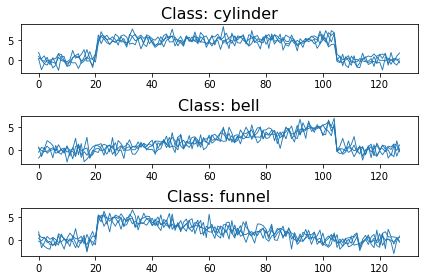

In [42]:
X, y = make_cylinder_bell_funnel(n_samples=12, random_state=42)

plt.figure()
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

### Display the splitted series grouped by class

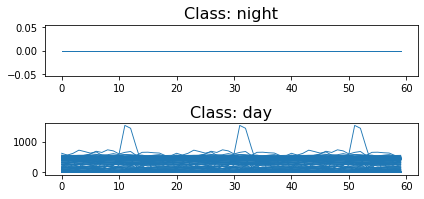

In [43]:
ts_labels=np.array(ts_light_labels)
ts=np.array(ts_light)

plt.figure()
for i, classe in enumerate(['night', 'day']):
    plt.subplot(3, 1, i + 1)
    for x in ts[ts_labels == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9)
plt.show()

### Shapelet finding

In [44]:
n_ts, ts_sz = ts.shape
n_classes = len(set(ts_labels))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

In [45]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        max_iter=3000,
                        verbose=1, 
                        random_state=42)

In [46]:
shp_clf.fit(ts, ts_labels)

Epoch 1/3000
405/405 [==============================] - 0s 919us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 3/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 4/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 5/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 6/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 7/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 8/3000
405/40

405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 60/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 61/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 62/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 63/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 64/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 65/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 66/3000
405/405 [====

Epoch 117/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 118/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 119/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 120/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 121/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 122/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 123/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 

405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 175/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 176/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 177/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 178/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 179/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 180/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 181/3000
405/40

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 232/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 233/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 234/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 235/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 236/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 237/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 238/3000
405/40

405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 289/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 290/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 291/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 292/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 293/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 294/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 295/3000
405/40

405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 346/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 347/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 348/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 349/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 350/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 351/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 352/3000
405/40

405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 403/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 404/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 405/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 406/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 407/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 408/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 409/3000
405/40

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 460/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 461/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 462/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 463/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 464/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 465/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 466/3000
405/40

405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 517/3000
405/405 [==============================] - 0s 55us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 518/3000
405/405 [==============================] - 0s 49us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 519/3000
405/405 [==============================] - 0s 51us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 520/3000
405/405 [==============================] - 0s 51us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 521/3000
405/405 [==============================] - 0s 56us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 522/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 523/3000
405/40

405/405 [==============================] - 0s 61us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 574/3000
405/405 [==============================] - 0s 51us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 575/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 576/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 577/3000
405/405 [==============================] - 0s 65us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 578/3000
405/405 [==============================] - 0s 52us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 579/3000
405/405 [==============================] - 0s 52us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 580/3000
405/40

405/405 [==============================] - 0s 55us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 631/3000
405/405 [==============================] - 0s 51us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 632/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 633/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 634/3000
405/405 [==============================] - 0s 49us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 635/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 636/3000
405/405 [==============================] - 0s 54us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 637/3000
405/40

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 688/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 689/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 690/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 691/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 692/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 693/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 694/3000
405/40

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 745/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 746/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 747/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 748/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 749/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 750/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 751/3000
405/40

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 802/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 803/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 804/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 805/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 806/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 807/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 808/3000
405/40

405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 859/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 860/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 861/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 862/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 863/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 864/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 865/3000
405/40

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 916/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 917/3000
405/405 [==============================] - 0s 47us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 918/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 919/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 920/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 921/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 922/3000
405/40

405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 973/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 974/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 975/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 976/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 977/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 978/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 979/3000
405/40

405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1030/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1031/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1032/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1033/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1034/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1035/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1036/3000

405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1087/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1088/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1089/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1090/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1091/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1092/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1093/3000

405/405 [==============================] - 0s 46us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1144/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1145/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1146/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1147/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1148/3000
405/405 [==============================] - 0s 43us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1149/3000
405/405 [==============================] - 0s 47us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1150/3000

405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1201/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1202/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1203/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1204/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1205/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1206/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1207/3000

405/405 [==============================] - 0s 44us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1258/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1259/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1260/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1261/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1262/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1263/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1264/3000

405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1315/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1316/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1317/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1318/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1319/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1320/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1321/3000

405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1372/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1373/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1374/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1375/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1376/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1377/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1378/3000

405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1429/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1430/3000
405/405 [==============================] - 0s 46us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1431/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1432/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1433/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1434/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1435/3000

405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1486/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1487/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1488/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1489/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1490/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1491/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1492/3000

405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1543/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1544/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1545/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1546/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1547/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1548/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1549/3000

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1600/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1601/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1602/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1603/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1604/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1605/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1606/3000

405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1657/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1658/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1659/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1660/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1661/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1662/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1663/3000

405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1714/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1715/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1716/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1717/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1718/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1719/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1720/3000

405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1771/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1772/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1773/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1774/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1775/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1776/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1777/3000

405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1828/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1829/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1830/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1831/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1832/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1833/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1834/3000

405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1884/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1885/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1886/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1887/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1888/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1889/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1890/3000

405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1941/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1942/3000
405/405 [==============================] - 0s 40us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1943/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1944/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1945/3000
405/405 [==============================] - 0s 42us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1946/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1947/3000

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1998/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 1999/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2000/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2001/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2002/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2003/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2004/3000

405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2055/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2056/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2057/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2058/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2059/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2060/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2061/3000

405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2112/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2113/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2114/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2115/3000
405/405 [==============================] - 0s 41us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2116/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2117/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2118/3000

405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2169/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2170/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2171/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2172/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2173/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2174/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2175/3000

405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2226/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2227/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2228/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2229/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2230/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2231/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2232/3000

405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2283/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2284/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2285/3000
405/405 [==============================] - 0s 24us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2286/3000
405/405 [==============================] - 0s 23us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2287/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2288/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2289/3000

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2339/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2340/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2341/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2342/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2343/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2344/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2345/3000

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2395/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2396/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2397/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2398/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2399/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2400/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2401/3000

405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2452/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2453/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2454/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2455/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2456/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2457/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2458/3000

405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2509/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2510/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2511/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2512/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2513/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2514/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2515/3000

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2566/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2567/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2568/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2569/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2570/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2571/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2572/3000

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2623/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2624/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2625/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2626/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2627/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2628/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2629/3000

405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2680/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2681/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2682/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2683/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2684/3000
405/405 [==============================] - 0s 38us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2685/3000
405/405 [==============================] - 0s 33us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2686/3000

405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2736/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2737/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2738/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2739/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2740/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2741/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2742/3000

405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2793/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2794/3000
405/405 [==============================] - 0s 35us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2795/3000
405/405 [==============================] - 0s 37us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2796/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2797/3000
405/405 [==============================] - 0s 29us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2798/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2799/3000

405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2849/3000
405/405 [==============================] - 0s 36us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2850/3000
405/405 [==============================] - 0s 39us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2851/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2852/3000
405/405 [==============================] - 0s 31us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2853/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2854/3000
405/405 [==============================] - 0s 32us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2855/3000

405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2906/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2907/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2908/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2909/3000
405/405 [==============================] - 0s 25us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2910/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2911/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2912/3000

405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2963/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2964/3000
405/405 [==============================] - 0s 28us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2965/3000
405/405 [==============================] - 0s 26us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2966/3000
405/405 [==============================] - 0s 27us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2967/3000
405/405 [==============================] - 0s 30us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2968/3000
405/405 [==============================] - 0s 34us/step - loss: 8.0700 - binary_accuracy: 0.4938 - binary_crossentropy: 8.0700
Epoch 2969/3000

ShapeletModel(batch_size=256, max_iter=3000, n_shapelets_per_size={6: 4},
              optimizer='sgd', random_state=42, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.0)

In [47]:
predicted_labels = shp_clf.predict(ts)
print("Correct classification rate:", accuracy_score(ts_labels, predicted_labels))

405/405 [==============================] - 0s 365us/step
Correct classification rate: 0.49382716049382713


In [48]:
predicted_locations = shp_clf.locate(ts)

C:\Users\xhuli\anaconda3\lib\site-packages\tslearn\utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 405 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


405/405 [==============================] - 0s 465us/step


### Display time series number 43 and its shapelets

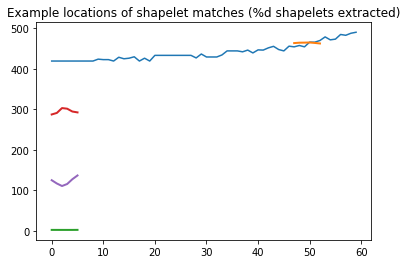

In [49]:
ts_id = 43
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(ts[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

### Matrix profile 

In [50]:
from matrixprofile import *

C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning: invalid value encountered in less
  idsToUpdate = distanceProfile < mp
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\xhuli\anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: 

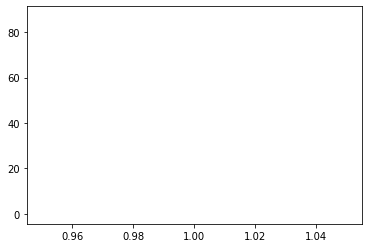

In [54]:
w = 60
mp = matrixProfile.stomp(ts.flatten(), w)

### Motifs

In [55]:
mtfs ,motif_d  = motifs.motifs(ts.flatten(), mp, max_motifs=10)